In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn import linear_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso,LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
car_dummy = pd.read_csv("dummy_df.csv")
car_dummy.drop(car_dummy.columns[[0]], axis=1, inplace=True)
car_dummy

,price,Intercept,year1,manufactureralfa-romeo,manufactureraudi,manufacturerbmw,manufacturerbuick,manufacturercadillac,manufacturerchevrolet,manufacturerchrysler,...,typeSUV,typetruck,typevan,typewagon,paint_colorblue,paint_colorother,paint_colorgrey,paint_colorred,paint_colorsilver,paint_colorwhite
0,6850,1,1,0,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,4900,1,1,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0
2,7800,1,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0
3,13500,1,1,0,0,0,0,0,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5400,1,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9269,25590,1,0,0,0,0,1,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9270,30990,1,0,0,0,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9271,12990,1,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9272,24990,1,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score

# Create a KNN imputer object
imputer = KNNImputer(n_neighbors=5)

# Impute missing values
car_dummy = pd.DataFrame(imputer.fit_transform(car_dummy), columns=car_dummy.columns)

X = car_dummy.iloc[:,2:] # here I remove the intercept column (not sure)
y = car_dummy.iloc[:,0]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

base_mod = linear_model.Lasso(tol=0.1)
scores = cross_val_score(base_mod, X_scaled, y, scoring='r2', cv=5)
print("scores_mean:", scores.mean(), "scores_std:", scores.std())
print("mod_params:", base_mod.get_params())
base_mod.fit(X_scaled,y)
print("mod_coef:", base_mod.coef_, "mod_size:", base_mod.coef_.size)

scores_mean: 0.6544030546491035 scores_std: 0.03522254263966384
mod_params: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.1, 'warm_start': False}
mod_coef: [-4431.95353054   336.44642706   331.50182965    60.52370935
   -90.86666935    74.41056951   123.71446109  -326.8869688
    11.15675137  -347.61087141  -194.25831606  -170.95373791
   127.8300933     21.56691533    95.762308    -296.040492
   105.51593925   121.93070116    43.68824406  -391.66452353
   727.32772765    51.9282915    -28.78770078    50.02604044
  -165.94408724   -18.85321108  -125.03751614  -460.46729058
    83.99442495   154.2714876    -21.44122369   249.7294883
   -38.2812377   -137.44135051   177.44566852   127.96333922
   -78.7774371     -0.          -816.76832828   -97.11044261
   226.34810488   232.60467694  -157.8524107     91.61082928
  -255.97705148 -1549.06952813  -323.36329424  -472.90662

In [4]:
# References: https://gist.github.com/daien/1272551/edd95a6154106f8e28209a1c7964623ef8397246
def euclidean_proj_simplex(v, s=1):
    """ 
    Helper function to compute the Euclidean projection on a positive simplex 
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # check if we are already on the simplex
    if v.sum() == s and np.alltrue(v >= 0):
        # best projection: itself!
        return v
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = float(cssv[rho] - s) / (rho+1)
    # compute the projection by thresholding v using theta
    w = (v - theta).clip(min=0)
    return w

def euclidean_proj_l1ball(v, s=1):
    """ 
    Helper function to compute the Euclidean projection on a L1-ball  
    """
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  # will raise ValueError if v is not 1-D
    # compute the vector of absolute values
    u = np.abs(v)
    # check if v is already a solution
    if u.sum() <= s:
        # L1-norm is <= s
        return v
    # v is not already a solution: optimum lies on the boundary (norm == s)
    # project *u* on the simplex
    w = euclidean_proj_simplex(u, s=s)
    # compute the solution to the original problem on v
    w *= np.sign(v)
    return w

def score(y_true, y_pred):
    """ 
    Helper function to compute R-squared.
    """
    u = ((y_true - y_pred)** 2).sum()
    v = ((y_true - y_true.mean()) ** 2).sum()
    return (1-u/v)

In [5]:
# MAIN ALGORITHM: 
def lasso_missing(X, y, l, R, g=1e8, rho=0.12):
    """
    Implements improved Lasso with missing data
    
    Params:
    ---------------------
    X: design matrix
    y: outcome variable
    l: penalty (level of threshold): can be used to shrink or threshold the coefficients of a model towards zero
    R: Radius of l1-ball
    g: stepwise parameter
    rho: probability of being missing
    
    Returns: estimated coefficients beta    
    """
    
    def Sigma_tilde(X, rho):
        Z = pd.DataFrame(X).fillna(0)
        n = Z.shape[0]
        Z_tilde = Z/(1-rho)
        Tau = (np.transpose(Z_tilde) @ Z_tilde / n).to_numpy() - rho*np.diag(np.diag(np.transpose(Z_tilde) @ Z_tilde))
        return Tau

    def Alpha_tilde(X, y, rho):
        Z = pd.DataFrame(X).fillna(0)
        n = Z.shape[0]
        Z_tilde = Z/(1-rho)
        Gamma = ( (1/n) * np.transpose(Z_tilde) @ y).to_numpy()
        return Gamma

    # gradient
    def grad(Sigma, alpha, beta):
        return (Sigma @ beta - alpha)

    # soft_thresholding
    def soft_threshold(beta_cur, g, l):
            # Sigma = Sigma_tilde(X, rho)
            # alpha = Alpha_tilde(X, y, rho)
            Sigma = Sigma_tilde(pd.DataFrame(X), rho) # for simulation, no need to pd.DF for car dataset (already pd)
            alpha = Alpha_tilde(pd.DataFrame(X), y, rho)
            gradient = grad(Sigma, alpha, beta_cur)
            vector = beta_cur - (1/g)*gradient
            v = np.array( [np.sign(x) * np.maximum(0,np.abs(x) - l) for x in vector] )
            return v

    # parameters
    p = X.shape[1]
    n = X.shape[0]
    beta_cur = beta_init
    N=20

    for i in range(N):
        v = soft_threshold(beta_cur, g, l) # <- step 1: soft-threshold at level l
        if np.linalg.norm(v, ord=1) > R:
            v = euclidean_proj_l1ball(v, R) # <- step 2: update v by euclidean projection onto l1-ball
            #v = project_onto_l1_ball(torch.tensor(v), R).numpy()
        beta_cur = v # update beta_cur
    return beta_cur

In [6]:
car_dummy = pd.read_csv("dummy_df.csv")
car_dummy.drop(car_dummy.columns[[0]], axis=1, inplace=True)
X = car_dummy.iloc[:,2:]
y = car_dummy.iloc[:,0]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# add intercept to X_scaled
X_scaled = np.column_stack((np.ones((X_scaled.shape[0], 1)), X_scaled))
print("X_scaled:", X_scaled, "dim:", X_scaled.shape)

beta_init = np.insert(base_mod.coef_, 0, base_mod.intercept_)
print(base_mod.intercept_, beta_init)

X_scaled: [[ 1.          1.04050032 -0.04986199 ... -0.35211231 -0.42693018
  -0.6021002 ]
 [ 1.          1.04050032 -0.04986199 ... -0.35211231 -0.42693018
  -0.6021002 ]
 [ 1.          1.04050032 -0.04986199 ... -0.35211231 -0.42693018
  -0.6021002 ]
 ...
 [ 1.          1.04050032 -0.04986199 ... -0.35211231 -0.42693018
  -0.6021002 ]
 [ 1.          1.04050032 -0.04986199 ... -0.35211231 -0.42693018
  -0.6021002 ]
 [ 1.         -0.96107611 -0.04986199 ... -0.35211231 -0.42693018
  -0.6021002 ]] dim: (9274, 86)
15468.167780892818 [ 1.54681678e+04 -4.43195353e+03  3.36446427e+02  3.31501830e+02
  6.05237093e+01 -9.08666694e+01  7.44105695e+01  1.23714461e+02
 -3.26886969e+02  1.11567514e+01 -3.47610871e+02 -1.94258316e+02
 -1.70953738e+02  1.27830093e+02  2.15669153e+01  9.57623080e+01
 -2.96040492e+02  1.05515939e+02  1.21930701e+02  4.36882441e+01
 -3.91664524e+02  7.27327728e+02  5.19282915e+01 -2.87877008e+01
  5.00260404e+01 -1.65944087e+02 -1.88532111e+01 -1.25037516e+02
 -4.6046

In [7]:
coef_lasso_NA = lasso_missing(X_scaled, y, g=1e7, l=0.9, R=1e8, rho=0.12)
print("mod_coef:", coef_lasso_NA, "size:", coef_lasso_NA.size)
def score(outcome_true, outcome_pred):
    u = ((outcome_true - outcome_pred)**2).sum()
    v = ((outcome_true - outcome_true.mean())** 2).sum()
    return (1-u/v)

# Create a KNN imputer object
imputer = KNNImputer(n_neighbors=5)

# Impute missing values
car_dummy = pd.DataFrame(imputer.fit_transform(car_dummy), columns=car_dummy.columns)

X = car_dummy.iloc[:,2:] # here I remove the intercept column (not sure)
y = car_dummy.iloc[:,0]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = np.column_stack((np.ones((X_scaled.shape[0], 1)), X_scaled))
X_scaled.shape

pred = np.dot(X_scaled, coef_lasso_NA)
print(score(y, pred))

mod_coef: [ 1.54946573e+04 -4.42668335e+03  3.19390081e+02  3.14431224e+02
  4.26733102e+01 -7.31038101e+01  5.66001047e+01  1.06046049e+02
 -3.09803252e+02  0.00000000e+00 -3.30586685e+02 -1.76792874e+02
 -1.53420798e+02  1.10173638e+02  3.60442254e+00  7.80132949e+01
 -2.78868052e+02  8.77949303e+01  1.04257009e+02  2.57894203e+01
 -3.74767318e+02  7.11396386e+02  3.40531179e+01 -1.08460720e+01
  3.21454953e+01 -1.48397041e+02 -8.82985129e-01 -1.07373081e+02
 -4.43768070e+02  6.62116629e+01  1.36690995e+02 -3.47831347e+00
  2.32423752e+02 -2.03668802e+01 -1.19812468e+02  1.59931681e+02
  1.10307129e+02 -6.09798442e+01 -0.00000000e+00 -8.00397148e+02
 -7.92899750e+01  2.08787242e+02  2.15056361e+02 -1.40153365e+02
  7.37658818e+01 -2.38438573e+02 -1.53394302e+03 -3.05950516e+02
 -4.55773356e+02  0.00000000e+00 -1.29798502e+02 -1.25598611e+02
 -8.77364332e+02 -3.83011863e+02 -3.86850923e+02 -7.66749935e+02
  3.34262841e+01 -1.50029878e+02 -2.28197599e+01 -2.15498192e+02
 -2.96006826e+0

# Refit the lasso-missing model

In [26]:
car_dummy = pd.read_csv("dummy_df.csv")
car_dummy.drop(car_dummy.columns[[0]], axis=1, inplace=True)

# Create a KNN imputer object
imputer = KNNImputer(n_neighbors=5)

# Impute missing values
car_dummy = pd.DataFrame(imputer.fit_transform(car_dummy), columns=car_dummy.columns)

X = car_dummy.iloc[:,2:] # here I remove the intercept column (not sure)
y = car_dummy.iloc[:,0]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# fit linear regression
LR_model = LinearRegression()
LR_result = LR_model.fit(X_train, y_train)
LR_predict = LR_model.predict(X_test)
LR_scores = cross_val_score(LR_model, X_train, y_train, scoring='r2', cv=5)
LR_scores.mean()

0.6586818819285722

In [28]:
# define the lasso_missing regressor

from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
from sklearn.linear_model import LinearRegression

class CustomRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self, coefficients):
        self.coefficients = coefficients
        self.lr = LinearRegression()
        
    def fit(self, X, y):
        self.lr.fit(X, y)
        return self
    
    def predict(self, X):
        return np.dot(X, self.coefficients)

In [29]:
# add the intercept to X_scaled
X_scaled = np.column_stack((np.ones((X_scaled.shape[0], 1)), X_scaled))
X_scaled.shape

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# check the fitness
custom_reg = CustomRegressor(coefficients=coef_lasso_NA)
custom_reg.fit(X_train, y_train)
custom_reg.predict(X_train)

array([11342.61740997, 10845.00338759, 23746.37356433, ...,
       11982.82165388, 21159.78164186, 13587.08792665])

In [30]:
# use custom regressor to get R^2 
model = CustomRegressor(coefficients=coef_lasso_NA)
scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=5)
scores.mean()

0.6746042279152974

In [31]:
# check the r^2 of basic models
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,Ridge,ElasticNet,BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR


# Define the degree of the polynomial (2, 3, etc.)
degree = 2

# Define the Polynomial Regression model pipeline
poly_model = make_pipeline(
    PolynomialFeatures(degree),
    LinearRegression()
)

# define models
models = []
#models.append(('LR', LinearRegression()))
# models.append(('DTR', DecisionTreeRegressor()))
# models.append(('RFR', RandomForestRegressor()))
models.append(('KNR', KNeighborsRegressor()))
models.append(('Ridge',Ridge(alpha=1)))
models.append(('Elastic',ElasticNet(alpha=1, l1_ratio=0.5)))
models.append(('Bayesian Ridge', BayesianRidge()))
# models.append(('SVR', LinearSVR()))
# models.append(('XGBR', XGBRegressor()))
# models.append(('LGBMR', LGBMRegressor()))
models.append(('Lasso', linear_model.Lasso(tol=0.1)))
models.append(('Lasso_missing',CustomRegressor(coefficients=coef_lasso_NA)))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    scores = cross_val_score(model, X_scaled, y, scoring='r2', cv=5)
    results.append(scores)
    names.append(name)
    print('%s: %.4f (%.4f)' % (name, scores.mean(), scores.std()))

KNR: 0.5928 (0.0786)
Ridge: 0.6542 (0.0352)
Elastic: 0.6157 (0.0274)
Bayesian Ridge: 0.6544 (0.0350)
Lasso: 0.6544 (0.0352)
Lasso_missing: 0.6668 (0.0359)


In [32]:
# Example: Combine predictions of multiple models using VotingRegressor
from sklearn.ensemble import VotingRegressor, BaggingRegressor
from sklearn.metrics import r2_score

from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
    
#custom_reg = CustomRegressor(coefficients=coef_lasso_NA)
#model1 = LR_result
#model2 = linear_model.Lasso(tol=0.1)
#model3 = Ridge(alpha=1)

custom_reg = CustomRegressor(coefficients=coef_lasso_NA)
model1 =  KNeighborsRegressor()
model2 = linear_model.Lasso(alpha=0.1,random_state=42)
model3 = LR_result


#voting_model = VotingRegressor([('Lasso_missing', custom_reg), ('LR', model1), ('Lasso', model2),('Ridge',model3)])
voting_model = VotingRegressor([('Lasso_missing', custom_reg), ('KN', model1), ('Lasso', model2),('LR', model3)])
voting_model.fit(X_train, y_train)

# Evaluate performance on test set
y_pred = voting_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared on test set:", r2)


R-squared on test set: 0.6799352772430859


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.544e+10, tolerance: 5.874e+07
  model = cd_fast.enet_coordinate_descent(


In [33]:
## fit meta model

# Use the Random Forest model to make predictions
#y_pred_rf = rf.predict(X_test)
y_pred = voting_model.predict(X_test)

# Add the predictions to the DataFrame
#car_dummy['rf_predictions'] = y_pred_rf

# Create an SVR meta-regressor
meta_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Use the predictions from the voting regressor on the training data as input to the meta-model
meta_X_train = voting_model.predict(X_train).reshape(-1, 1)

# Fit the meta-model on the training data
meta_model.fit(meta_X_train, y_train)

# Use the trained meta-model to make predictions on the test data
y_pred_meta = meta_model.predict(voting_model.predict(X_test).reshape(-1, 1))

# Calculate the R squared of the meta-model on the test data
meta_score = meta_model.score(voting_model.predict(X_test).reshape(-1, 1), y_test)

# Print the R squared of the meta-model on the test data
print('Meta-Model R squared: {:.4f}'.format(meta_score))


Meta-Model R squared: 0.7080


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.544e+10, tolerance: 5.874e+07
  model = cd_fast.enet_coordinate_descent(


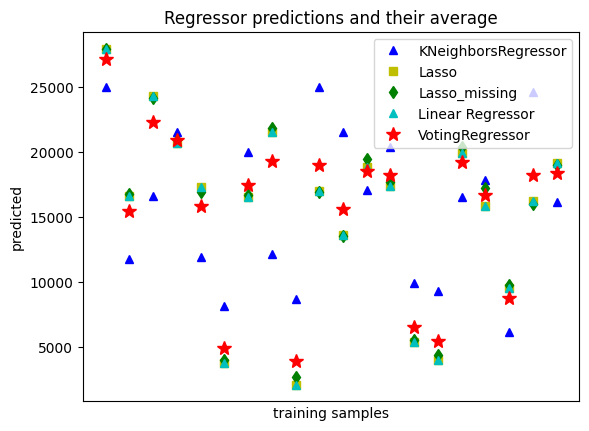

In [37]:

custom_reg.fit(X_train, y_train)
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

#use each of the regressors to make the 20 first predictions.
X_test_20 = X_test[:20]
pred1 = custom_reg.predict(X_test_20)
pred2 = model1.predict(X_test_20)
pred3 = model2.predict(X_test_20)
pred4 = LR_predict[:20]
pred5 = voting_model.predict(X_test_20)

plt.figure()
plt.plot(pred2, "b^", label="KNeighborsRegressor")
plt.plot(pred3, "ys", label="Lasso")
plt.plot(pred1, "gd", label="Lasso_missing")
plt.plot(pred4, "c^", label="Linear Regressor")
plt.plot(pred5, "r*", ms=10, label="VotingRegressor")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()